In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import time

In [2]:
data=np.loadtxt(open('mnist_train_small.csv','rb'),delimiter=',')
data.shape
label=data[:,0]
data=data[:,1:]
print(label.shape)
print(data.shape)

(20000,)
(20000, 784)


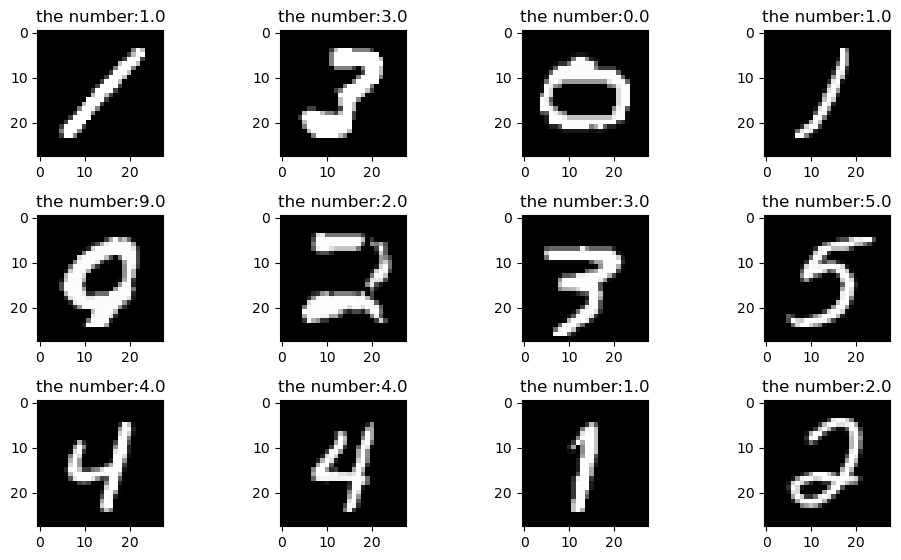

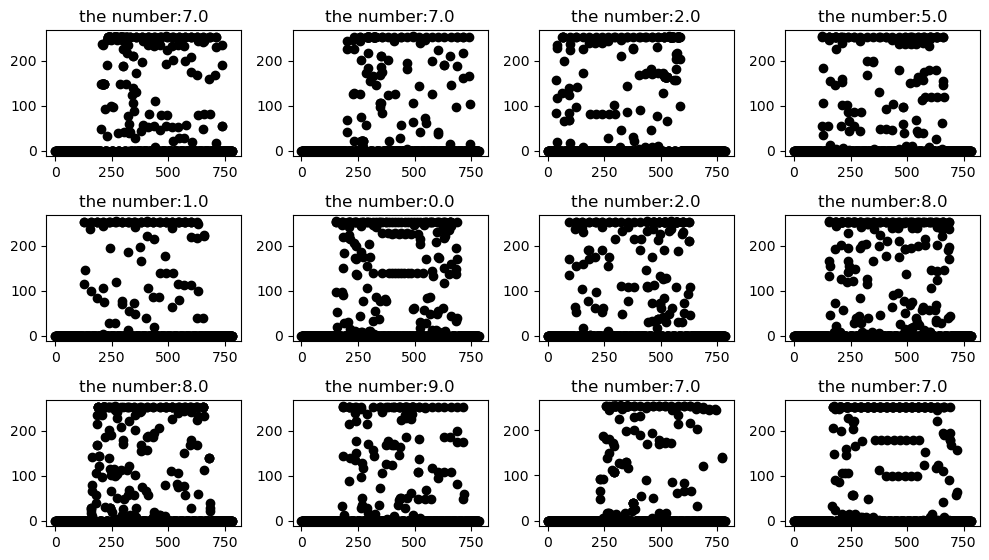

In [4]:
fig,axs=plt.subplots(3,4,figsize=(10,6))
for ax in axs.flatten():
    randimg=np.random.randint(0,data.shape[0])
    img=np.reshape(data[randimg,:],(28,28))
    ax.imshow(img,cmap='gray')
    
    ax.set_title(f'the number:{label[randimg]}')
plt.tight_layout(rect=[0,0,1,.95])

fig,axs=plt.subplots(3,4,figsize=(10,6))
for ax in axs.flatten():
    randimg=np.random.randint(0,data.shape[0])
    ax.plot(data[randimg,:],'ko')
    
    ax.set_title(f'the number:{label[randimg]}')
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

import dataset and normalize to between of 0 and 1

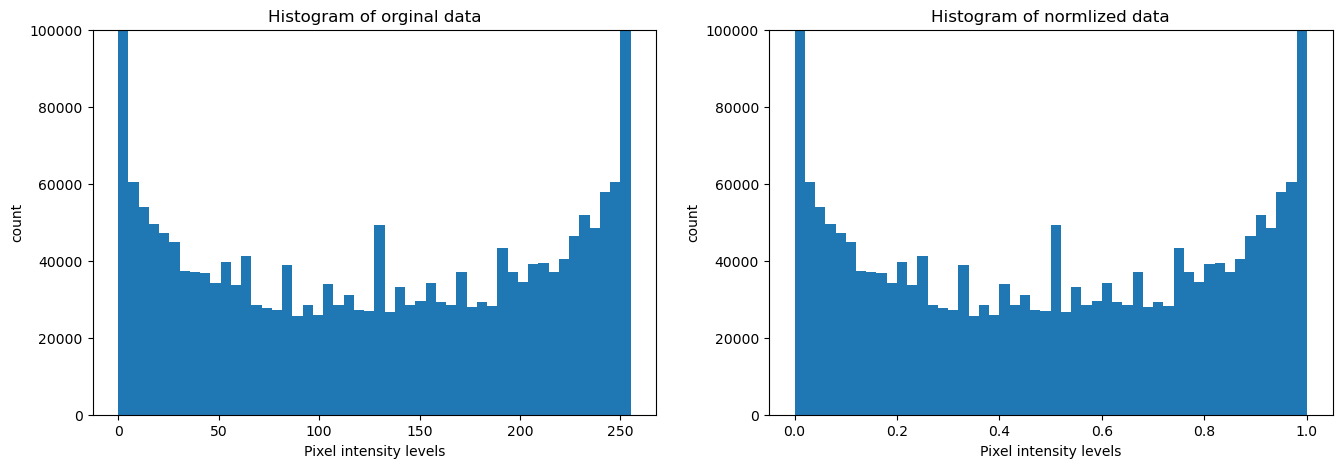

In [4]:
data=np.loadtxt(open('mnist_train_small.csv','rb'),delimiter=',')
label=data[:,0]
data=data[:,1:]

normdata=data/np.max(data)

fig,ax=plt.subplots(1,2,figsize=(16,5))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity levels')
ax[0].set_ylabel('count')
ax[0].set_title('Histogram of orginal data')
ax[0].set_ylim(top=1e5)

ax[1].hist(normdata.flatten(),50)
ax[1].set_xlabel('Pixel intensity levels')
ax[1].set_ylabel('count')
ax[1].set_title('Histogram of normlized data')
ax[1].set_ylim(top=1e5)
plt.show()

data split to train and test

In [5]:
dataTen=torch.tensor(normdata).float()
labelTen=torch.tensor(label).long()

train_data,test_data,train_label,test_label=train_test_split(dataTen,labelTen,test_size=.1)

train_dataset=TensorDataset(train_data,train_label)
test_dataset=TensorDataset(test_data,test_label)

train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True,drop_last=True)
test_loader=DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])

the deep learning model

In [4]:
def create_model():   
    
    class neural_network_mnist(nn.Module):
        
        def __init__(self,dropRate=0.):
            super().__init__()

            self.input=nn.Linear(784,64)
            
            self.dr=dropRate

            self.hidden_1=nn.Linear(64,128)
            self.bNorm1=nn.BatchNorm1d(64)

            self.hidden_2=nn.Linear(128,128)
            self.bNorm2=nn.BatchNorm1d(128)

            self.hidden_3=nn.Linear(128,64)
            self.bNorm3=nn.BatchNorm1d(128)

            self.output=nn.Linear(64,10)

        def forward(self,x,bN=False):
            x=F.relu(self.input(x))
            
            if bN:
                x=F.dropout(x,p=self.dr,training=self.training)
                
                x=self.bNorm1(x)
                x=F.relu(self.hidden_1(x))
                x=F.dropout(x,p=self.dr,training=self.training)

                x=self.bNorm2(x)
                x=F.relu(self.hidden_2(x))
                x=F.dropout(x,p=self.dr,training=self.training)
                
                x=self.bNorm3(x)
                x=F.relu(self.hidden_3(x)) 
                x=F.dropout(x,p=self.dr,training=self.training)

            else:
                x=F.relu(self.hidden_1(x))
                x=F.relu(self.hidden_2(x))
                x=F.relu(self.hidden_3(x))

            return self.output(x)
        
    #neural network
    ANN=neural_network_mnist(0.)
    
    #loss function
    lossfun=nn.CrossEntropyLoss()
    
    #optimizer stochaid gradient descent
    optimizer=torch.optim.SGD(ANN.parameters(),lr=.1)
    
    return ANN, lossfun, optimizer

In [5]:
def weight_histogram(ann):
    W=np.array([])
    
    for layer in ann.parameters():
        W=np.concatenate((W,layer.detach().flatten().numpy()))
        
    histy,histx=np.histogram(W,bins=np.linspace(-.8,.8,101),density=True)
    histx = (histx[1:]+histx[:-1])/2    
    return histx,histy

In [6]:
import time
def trainModel(Numepoch=20,do_bn=False):
    
    trainAcc=[]
    testAcc=[]
    losses=torch.zeros(Numepoch)
    
    processTime=time.process_time()
    
    ANN, lossfun, optimizer=create_model()
    
    histx=np.zeros((Numepoch,100))
    histy=np.zeros((Numepoch,100))
    
    for epoch in range(Numepoch):
        startTime=time.process_time()
        
        histx,histy[epoch,:]=weight_histogram(ANN)
        
        batchAcc=[]
        batchLoss=[]
        
        ANN.train()
        
        for dat,lab in train_loader:
            
            yHat=ANN(dat,do_bn)
            loss=lossfun(yHat,lab)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            match=(torch.argmax(yHat,axis=1)==lab).float()
            batchAcc.append(100*torch.mean(match))
            
            batchLoss.append(loss.item())
        
        #we use numpy mean, because batchAcc consist of several tensor datasets
        trainAcc.append(np.mean(batchAcc)) 
        
        losses[epoch]=np.mean(batchLoss)
        
        #set netwok as eval
        ANN.eval()
        
        dat,lab=next(iter(test_loader))
        with torch.no_grad():
            yHat=ANN(dat)
            
        match=(torch.argmax(yHat,axis=1)==lab).float()
        testAcc.append(100*torch.mean(match).item())
        
        completedTime=time.process_time() - startTime
        print(f'{epoch+1}-th step completed at {completedTime:.2f}-second')
        
    processTime=time.process_time() - processTime
    
    return ANN, trainAcc, testAcc, losses, histx, histy, processTime

In [7]:
ANN, trainAcc, testAcc, losses, histx, histy, processTime=trainModel(100,True)

1-th step completed at 0.30-second
2-th step completed at 0.33-second
3-th step completed at 0.48-second
4-th step completed at 0.48-second
5-th step completed at 0.00-second
6-th step completed at 0.00-second
7-th step completed at 0.00-second
8-th step completed at 0.00-second
9-th step completed at 0.05-second
10-th step completed at 12.00-second
11-th step completed at 49.12-second
12-th step completed at 67.03-second
13-th step completed at 89.58-second
14-th step completed at 86.12-second
15-th step completed at 98.28-second
16-th step completed at 94.94-second
17-th step completed at 95.52-second
18-th step completed at 89.36-second
19-th step completed at 59.30-second
20-th step completed at 36.83-second
21-th step completed at 83.11-second
22-th step completed at 75.36-second
23-th step completed at 87.67-second
24-th step completed at 92.11-second
25-th step completed at 90.31-second
26-th step completed at 88.53-second
27-th step completed at 93.56-second
28-th step complete

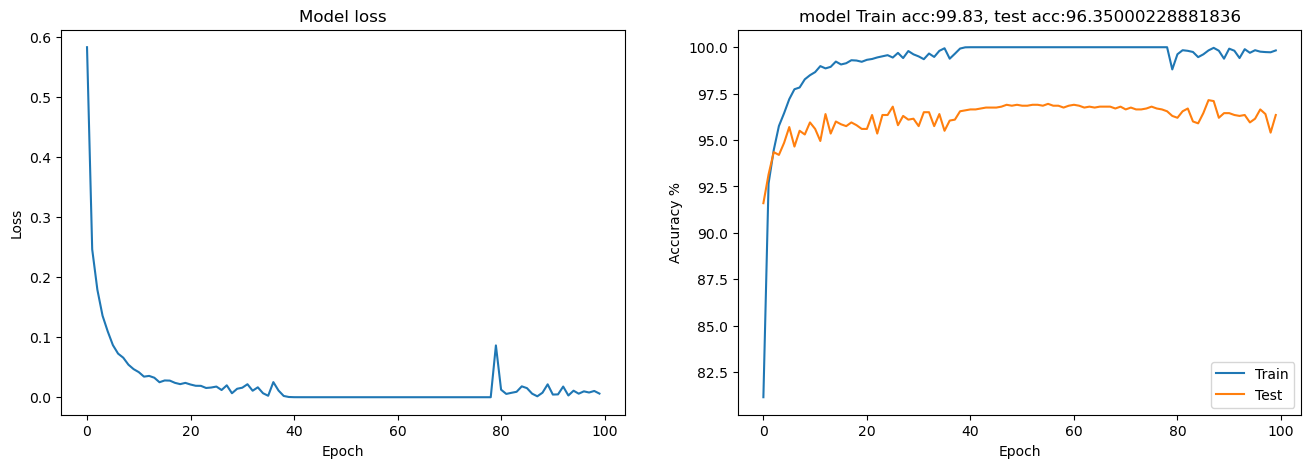

In [17]:
fig,axs=plt.subplots(1,2,figsize=(16,5))
axs[0].plot(losses)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Model loss')

axs[1].plot(trainAcc,label='Train')
axs[1].plot(testAcc,label='Test')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy %')
axs[1].set_title(f'model Train acc:{trainAcc[-1]:.2f}, test acc:{testAcc[-1]}')
axs[1].legend()


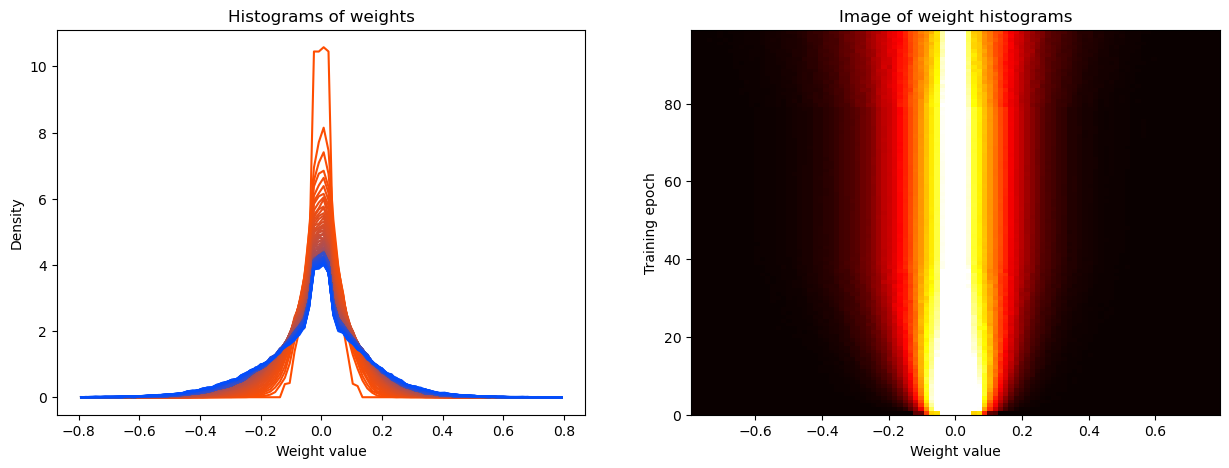

In [18]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

for i in range(histy.shape[0]):
    ax[0].plot(histx,histy[i,:],color=[1-i/100,.3,i/100])

ax[0].set_title('Histograms of weights')
ax[0].set_xlabel('Weight value')
ax[0].set_ylabel('Density')

ax[1].imshow(histy,vmin=0,vmax=3,
             extent=[histx[0],histx[-1],0,99],aspect='auto',origin='lower',cmap='hot')
ax[1].set_xlabel('Weight value')
ax[1].set_ylabel('Training epoch')
ax[1].set_title('Image of weight histograms')

plt.show()